In [2]:
import numpy as np
import random

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

import tensorflow as tf

import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, AveragePooling2D, AveragePooling1D
from keras.metrics import BinaryAccuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
X = np.load('ABIDE_X.npy', allow_pickle=True)
Y = np.load('ABIDE_Y.npy', allow_pickle=True)

In [4]:
# Since scans are 2s apart 90 scans is 3 mins
L = 90
# Number of clips per subject
N=10
# Number of ROIs
N_rois = 200
feat_name = 'filt_noglobal_roi_200_Cradd'
def extract_feat_sections(data, L=L, N=N):
    feat_secs = list()
    for i in range(N):
        r = int(random.random() * (len(data) - L))
        feat_secs.append(data[r:r+L])
    return np.array(feat_secs)

def create_dataset(X_arr, Y_arr, L=L,N=N):
    X = list()
    Y = list()
    for n, data in enumerate(X_arr):
        feat_secs = extract_feat_sections(data)
        X.extend(feat_secs)
        for i in range(len(feat_secs)):
            Y.append(Y_arr[n, 2])
    assert len(X) == len(Y)
    X_ar = np.array(X).reshape(len(X), L, N_rois)
    Y_ar = np.array(Y)
    return X_ar, Y_ar

In [5]:
# In original work 10 fold cross val used with proportion of subjects from each site was approximately the same in all folds
# To start will just randomly split subjects into groups
random_seed = 52
val_per = .05
test_per = .1
train_sub_X, val_sub_X, train_sub_Y, val_sub_Y = train_test_split(X, Y, test_size=val_per + test_per, random_state=random_seed)
val_sub_X, test_sub_X, val_sub_Y, test_sub_Y= train_test_split(val_sub_X, val_sub_Y, test_size=test_per/(val_per + test_per), random_state=random_seed + 1)
print(f'{len(train_sub_X)} subjects for training.')
print(f'{len(val_sub_X)} subjects for validation')
print(f'{len(test_sub_X)} subjects for testing')

806 subjects for training.
47 subjects for validation
96 subjects for testing


In [6]:
# Randomly extracts 10 shorter clips from each subject
train_X, train_Y = create_dataset(train_sub_X, train_sub_Y)
val_X, val_Y = create_dataset(val_sub_X, val_sub_Y)
test_X, test_Y = create_dataset(test_sub_X, test_sub_Y)
print(f'{len(train_X)} training examples')
print(f'{len(val_X)} validation examples')
print(f'{len(test_X)} testing examples')

8060 training examples
470 validation examples
960 testing examples


First evaluate performance of LSTM

In [48]:
# create and fit the LSTM network
# hidden_nodes = int(2/3 * (N_rois * L))
hidden_nodes = 16
model = Sequential()
model.add(LSTM(hidden_nodes, input_shape=(L, N_rois), return_sequences=True, dropout=0.5))
model.add(Dropout(0.5))
# model.add(LSTM(hidden_nodes))
# model.add(Dropout(0.25))
# model.add(AveragePooling2D(pool_size=(L, 1)))
model.add(AveragePooling1D(pool_size=L))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 90, 16)            13888     
_________________________________________________________________
dropout_26 (Dropout)         (None, 90, 16)            0         
_________________________________________________________________
average_pooling1d_2 (Average (None, 1, 16)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 1, 1)              17        
Total params: 13,905
Trainable params: 13,905
Non-trainable params: 0
_________________________________________________________________


In [49]:

batch_size = 32
epochs = 100
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
history = model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_Y), callbacks=[es_callback])


Epoch 1/100
252/252 [==============================] - 4s 9ms/step - loss: 0.6931 - accuracy: 0.5038 - val_loss: 0.6859 - val_accuracy: 0.5574
Epoch 2/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6862 - accuracy: 0.5608 - val_loss: 0.7003 - val_accuracy: 0.4745
Epoch 3/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6746 - accuracy: 0.6098 - val_loss: 0.6962 - val_accuracy: 0.5106
Epoch 4/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6557 - accuracy: 0.6607 - val_loss: 0.7057 - val_accuracy: 0.5319
Epoch 5/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6358 - accuracy: 0.6734 - val_loss: 0.7100 - val_accuracy: 0.5574
Epoch 6/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6163 - accuracy: 0.7027 - val_loss: 0.7139 - val_accuracy: 0.5702
Epoch 7/100
252/252 [==============================] - 2s 7ms/step - loss: 0.6027 - accuracy: 0.7034 - val_loss: 0.7125 - val_accuracy: 0.5979

In [50]:
# evaluate the model
_, train_acc = model.evaluate(train_X, train_Y, verbose=0)
_, test_acc = model.evaluate(test_X, test_Y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.910, Test: 0.601


Now with the Transformer model

In [9]:
train_X.shape

(8060, 90, 200)

In [7]:
# Add classifcation token to beginning of input
# classifcation token is an array of 0's and will be the input to the downstream classification tasks

def add_cls_token(X):
  cls_array = np.zeros((X.shape[0], 1, N_rois))
  t_X = np.append(cls_array, X, 1)
  return t_X


In [8]:
train_X_t = add_cls_token(train_X) 
val_X_t = add_cls_token(val_X) 
test_X_t = add_cls_token(test_X) 

In [9]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [13]:
embed_dim = N_rois  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
max_len = L + 1 # add one for the cls token
dropout_rate = .5

# inputs = layers.Input(shape=(max_len,))
inputs = layers.Input(shape=(max_len, embed_dim))
# embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
# x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = x[:, 0, :]
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 200)]         0         
_________________________________________________________________
transformer_block (Transform (None, 91, 200)           656432    
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                4020      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 21    

In [14]:
batch_size = 32
epochs = 100
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
model.fit(train_X_t, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X_t, val_Y), callbacks=[es_callback])

Epoch 1/100
252/252 [==============================] - 4s 13ms/step - loss: 0.8042 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5106
Epoch 2/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6939 - accuracy: 0.5012 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 3/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6933 - accuracy: 0.5057 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 4/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6934 - accuracy: 0.5101 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 5/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6928 - accuracy: 0.5106 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 6/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6929 - accuracy: 0.4959 - val_loss: 0.6930 - val_accuracy: 0.5106
Epoch 7/100
252/252 [==============================] - 3s 11ms/step - loss: 0.6925 - accuracy: 0.5027 - val_loss: 0.6930 - val_accuracy:

In [15]:
# evaluate the model
_, train_acc = model.evaluate(train_X_t, train_Y, verbose=0)
_, test_acc = model.evaluate(test_X_t, test_Y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.506, Test: 0.562


Train: 0.972, Test: 0.645

Transfomer with positional encoding

In [10]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.maxlen = maxlen
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=self.maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

In [11]:
embed_dim = N_rois  # Embedding size for each token
num_heads = 8  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
max_len = L + 1
dropout_rate = .5

# inputs = layers.Input(shape=(max_len,))
inputs = layers.Input(shape=(max_len, embed_dim))
pos_embedding_layer = PositionEmbedding(max_len, embed_dim)
x = pos_embedding_layer(inputs)
# x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = x[:, 0, :] # take only cls token
# x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(dropout_rate)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_embed = keras.Model(inputs=inputs, outputs=outputs)
model_embed.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_embed.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 91, 200)]         0         
_________________________________________________________________
position_embedding (Position (None, 91, 200)           18200     
_________________________________________________________________
transformer_block (Transform (None, 91, 200)           1298832   
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                4020      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [12]:
batch_size = 32
epochs = 100
es_callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15)
history = model_embed.fit(train_X_t, train_Y, batch_size=batch_size, epochs=epochs, validation_data=(val_X_t, val_Y), callbacks=[es_callback])

Epoch 1/100
252/252 [==============================] - 10s 21ms/step - loss: 0.7237 - accuracy: 0.5264 - val_loss: 0.6944 - val_accuracy: 0.4255
Epoch 2/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6939 - accuracy: 0.5024 - val_loss: 0.7024 - val_accuracy: 0.4255
Epoch 3/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6939 - accuracy: 0.5114 - val_loss: 0.6960 - val_accuracy: 0.4255
Epoch 4/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6933 - accuracy: 0.5139 - val_loss: 0.6956 - val_accuracy: 0.4255
Epoch 5/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6934 - accuracy: 0.5012 - val_loss: 0.6957 - val_accuracy: 0.4255
Epoch 6/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6917 - accuracy: 0.5118 - val_loss: 0.6939 - val_accuracy: 0.4255
Epoch 7/100
252/252 [==============================] - 5s 19ms/step - loss: 0.6841 - accuracy: 0.5267 - val_loss: 0.6782 - val_accuracy

In [15]:
# evaluate the model
_, train_acc = model_embed.evaluate(train_X_t, train_Y, verbose=0)
_, test_acc = model_embed.evaluate(test_X_t, test_Y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.974, Test: 0.584


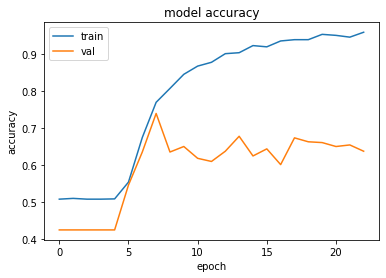

In [19]:
def plt_training(var, skip=0, exp_name=None):
  plt.plot(history.history[var][skip:])
  plt.plot(history.history['val_' + var][skip:])
  plt.title('model ' + var)
  plt.ylabel(var)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  if exp_name is not None:
    plt.savefig(f'{exp_name}_{var}.png')
  plt.show()
  

exp_name = 'L90_8_32_pure'
vars = ['loss', 'accuracy']
skip = 1
plt_training(vars[1], skip, exp_name)

In [ ]:
def pause():
  for i in range(1000230413254123041230421341234):
    if i %12132423423141324 == 0:
      print(i)

In [ ]:
pause()

0
